In [1]:
#!/usr/bin/env python

import sys
import re
import itertools
import datetime

import pandas as pd
pd.set_option('display.max_columns', 250)
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

from IPython.display import display

import pysam

In [2]:
print(datetime.datetime.today())

2017-08-18 15:31:34.391582


In [3]:
from extract_targets import extract_info

In [4]:
gtf = 'reference/Homo_sapiens.GRCh37.75.gtf'

In [5]:
# http://uswest.ensembl.org/info/website/upload/gff.html
names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
# adf: annotation df
print('reading {0}...'.format(gtf))
df = pd.read_csv(gtf, header=None, sep='\t', comment='#', low_memory=False, names=names)

reading reference/Homo_sapiens.GRCh37.75.gtf...


In [6]:
extract_info(df)

extracting length...
extracting transcript id...
extracting gene id...
extracting gene name...


# Count stop codons per gene

In [7]:
sc_count = df.query('source == "protein_coding"').groupby('gene_name').apply(lambda g: g.query('feature == "stop_codon"').shape[0])

In [8]:
sc_count.head()

gene_name
A1BG       1
A1CF       7
A2M        1
A2ML1      2
A3GALT2    2
dtype: int64

In [9]:
sc_count[sc_count > 1].shape[0] / float(sc_count.shape[0])

0.6791048406713694

about 68% of genes have multiple stop codons

# % of protein coding genes over whole genome

In [12]:
protein_coding_length = df.query('source == "protein_coding"').query('feature == "gene"')['len'].sum()

In [13]:
protein_coding_length

1395707084

In [14]:
protein_coding_length / 3e9

0.46523569466666664

In [15]:
protein_coding_exon_length = df.query('source == "protein_coding"').query('feature == "exon"')['len'].sum()

In [16]:
protein_coding_exon_length

192167710

In [17]:
protein_coding_exon_length / 3e9

0.064055903333333331

This number includes repeated count of multiple transcripts per gene

In [19]:
beg_end_pairs = df.query('source == "protein_coding"').query('feature == "exon"')[['start', 'end']].values

In [31]:
bases = set([])
for pair in beg_end_pairs:
    bases.update(np.arange(pair[0], pair[1]))

In [33]:
len(bases) / 3e9

0.021202568

Based on this calculation, it's about 2% of the genome that's protein-coding, NOT including introns

# See overlaps among genes

In [122]:
chrs = list(map(str, range(1, 23))) + ['X', 'Y', 'MT']

In [123]:
subdf = df.query('seqname in {0}'.format(chrs)).query('source in ["protein_coding", "nonsense_mediated_decay"]').query('feature == "gene"').copy()

In [124]:
subdf.shape

(20327, 12)

In [125]:
subdf.head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
109,1,protein_coding,gene,69091,70008,.,+,.,918,,ENSG00000186092,OR4F5
140,1,protein_coding,gene,134901,139379,.,-,.,4479,,ENSG00000237683,AL627309.1


In [126]:
subdf.groupby('seqname').count()['source'].sort_values(ascending=False).to_frame(name='count').T

seqname,1,19,11,2,17,3,12,6,7,5,16,X,9,10,4,8,14,15,20,22,13,18,21,Y,MT
count,2076,1481,1317,1281,1208,1078,1070,1052,917,893,875,830,805,771,767,701,652,617,560,450,329,288,242,54,13


Even chr1 has just a bit over 2k genes!

### look at one chr a time

In [127]:
chrdf = subdf.query('seqname == "1"').sort_values('start')

In [128]:
chrdf.shape

(2076, 12)

In [129]:
chrdf.head(10)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
109,1,protein_coding,gene,69091,70008,.,+,.,918,,ENSG00000186092,OR4F5
140,1,protein_coding,gene,134901,139379,.,-,.,4479,,ENSG00000237683,AL627309.1
276,1,protein_coding,gene,367640,368634,.,+,.,995,,ENSG00000235249,OR4F29
373,1,protein_coding,gene,621059,622053,.,-,.,995,,ENSG00000185097,OR4F16
510,1,protein_coding,gene,738532,739137,.,-,.,606,,ENSG00000269831,AL669831.1
605,1,protein_coding,gene,818043,819983,.,+,.,1941,,ENSG00000269308,AL645608.2
637,1,protein_coding,gene,860260,879955,.,+,.,19696,,ENSG00000187634,SAMD11
756,1,protein_coding,gene,861264,866445,.,-,.,5182,,ENSG00000268179,AL645608.1
771,1,protein_coding,gene,879584,894689,.,-,.,15106,,ENSG00000188976,NOC2L
853,1,protein_coding,gene,895967,901095,.,+,.,5129,,ENSG00000187961,KLHL17


In [130]:
gene_names = chrdf.gene_name.values

In [131]:
gn_pairs = np.concatenate([gene_names[0:1], np.repeat(gene_names[1:-1], 2), gene_names[-1:]]).reshape(-1, 2)

In [132]:
gn_pairs.shape

(2075, 2)

In [133]:
# pairs of (end_of_1st_gene, start_of_next_gene)
endstart = chrdf[['start', 'end']].values.ravel()[1:-1].reshape(-1, 2)

In [134]:
endstart_df = pd.DataFrame(endstart, columns=['gene1_end', 'gene2_start'])

In [135]:
endstart_df.shape

(2075, 2)

In [136]:
endstart_df['gene1'] = gn_pairs[:,0]

In [137]:
endstart_df['gene2'] = gn_pairs[:,1]

In [138]:
endstart_df.head(2)

,gene1_end,gene2_start,gene1,gene2
0,70008,134901,OR4F5,AL627309.1
1,139379,367640,AL627309.1,OR4F29


In [139]:
endstart_df['diff'] = endstart_df.gene2_start - endstart_df.gene1_end

In [140]:
endstart_df['has_overlap'] = endstart_df.apply(lambda row: row.diff < 0, axis=1)

In [141]:
endstart_df.head(2)

,gene1_end,gene2_start,gene1,gene2,diff,has_overlap
0,70008,134901,OR4F5,AL627309.1,64893,False
1,139379,367640,AL627309.1,OR4F29,228261,False


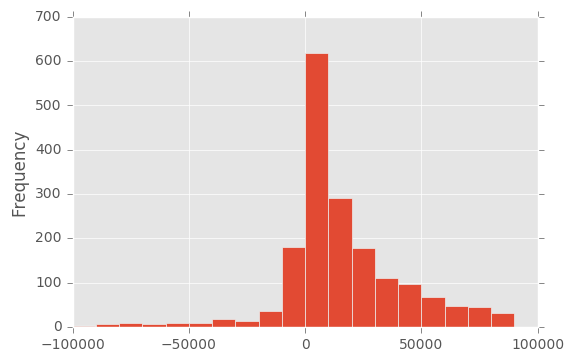

In [142]:
endstart_df['diff'].plot.hist(bins=np.arange(-1e5, 1e5, 1e4))

In [143]:
chrdf.shape

(2076, 12)

In [144]:
endstart_df.shape

(2075, 6)

In [145]:
endstart_df.query('diff < 0')['diff'].shape

(309,)

In [146]:
endstart_df.query('diff < 0').shape[0] / float(endstart_df.shape[0])

0.1489156626506024

So ~15% of genes overlap, that's quite a bit

## How many genes have multiple transcripts

In [6]:
gs = df[(df.source == 'protein_coding') & (df.feature.isin(['transcript']))].groupby('gene_id')

In [7]:
cdf = gs.count().ix[:,1]

In [8]:
cdf[cdf > 1].shape

(16627,)

In [9]:
cdf.shape

(22642,)

In [10]:
cdf[cdf > 1].shape[0] / float(cdf.shape[0])

0.7343432558961223

So over 73% of genes have more than one transcripts

## Show strand uniqueness per gene

In [11]:
res = df.groupby(['gene_id', 'gene_name']).apply(lambda g: g.strand.unique().shape[0])

In [12]:
res.shape

(63677,)

In [13]:
(res == 1).all()

True

Take a look at a few example where gene name is shared by multiple transcript id, so if gene_name and gene_id are mixed, it may lead to strand non-uniqueness

In [14]:
# df[df.gene_name == 'U1']

In [15]:
df.gene_id.unique().shape

(63677,)

That it returns True means all genes have only one unique strand.

## Distribution of distances between neighboring cleavage sites of the same gene in the annotation

In [16]:
df.head(1)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
0,1,pseudogene,gene,11869,14412,.,+,.,2544,,ENSG00000223972,DDX11L1


In [17]:
def calc_clv_site(transcript_row):
    if transcript_row.strand == '+':
        return transcript_row.end
    elif transcript_row.strand == '-':
        return transcript_row.start
    else:
        raise

In [18]:
%time clv_sites = df.query('source == "protein_coding"').query('feature == "transcript"').groupby(['gene_name', 'gene_id']).apply(lambda g: g.apply(calc_clv_site, axis=1))

CPU times: user 10.4 s, sys: 35 ms, total: 10.5 s
Wall time: 10.4 s


In [19]:
%time neighbor_dist = clv_sites.to_frame(name='clv_site').reset_index(level=[0, 1]).groupby(['gene_name', 'gene_id']).apply(lambda g: np.diff(np.sort(g.clv_site.unique())))

CPU times: user 1.48 s, sys: 1 ms, total: 1.48 s
Wall time: 1.48 s


In [20]:
ndser = pd.Series(np.concatenate(neighbor_dist.values))

In [21]:
ndser[ndser <= 20].shape[0] / float(ndser.shape[0])

0.20284296439023503

So 20% of the neighbouring cleavage sites in the annotation are <= 20 bp away.

See the distribution

In [22]:
ndser.describe(percentiles=np.arange(0, 1.01, 0.05)).astype(int).to_frame(name='distance').T

,count,mean,std,min,0%,5%,10%,15.0%,20%,25%,30.0%,35%,40%,45%,50%,55.0%,60.0%,65%,70%,75%,80%,85.0%,90%,95%,100%,max
distance,55013,7580,31822,1,1,2,4,8,20,40,74,128,211,332,518,789,1151,1663,2355,3449,5304,8707,15727,34007,1585161,1585161


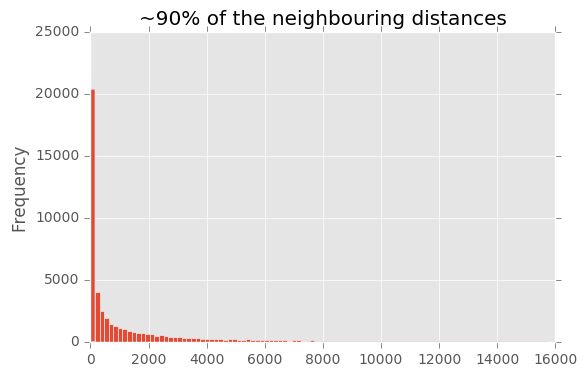

In [23]:
ax = ndser[ndser <= 15727].plot.hist(bins=100)
ax.set_title('~90% of the neighbouring distances')

## See how many cleavage sites correspond to multiple stop codons in the annotation

In [24]:
df.feature.value_counts()

exon              1306656
CDS                791856
UTR                304070
transcript         215170
stop_codon          73411
start_codon         73358
gene                63677
Selenocysteine        114
Name: feature, dtype: int64

In [25]:
def calc_clv_site_and_stop_codon(grp):
    strand = grp.strand.unique()[0]
    tran = grp.query('feature == "transcript"')
    stop = grp.query('feature == "stop_codon"')
    if strand == '+':
        clv_site = tran.end.values[0] if tran.shape[0] > 0 else -1
        stop_site = stop.end.values[0] if stop.shape[0] > 0 else -1
    elif strand == '-':
        clv_site = tran.start.values[0] if tran.shape[0] > 0 else -1
        stop_site = stop.start.values[0] if stop.shape[0] > 0 else -1
    return pd.Series([clv_site, stop_site])

In [26]:
%time clv_stop = df.query('source == "protein_coding"').query('feature in ["transcript", "stop_codon"]').groupby(['gene_name', 'gene_id', 'transcript_id']).apply(calc_clv_site_and_stop_codon)

CPU times: user 3min 17s, sys: 381 ms, total: 3min 18s
Wall time: 3min 18s


In [27]:
clv_stop.columns = ['clv_site', 'stop_codon_tail']

In [28]:
clv_stop = clv_stop.astype(int)

In [29]:
clv_stop.head(2)

clv_site  stop_codon_tail
gene_name gene_id         transcript_id                             
A1BG      ENSG00000121410 ENST00000263100  58858216         58858388
                          ENST00000600966  58861960               -1

In [30]:
# scc stop_codons_count; > 0 remove entries that have stop_codon_tail == -1
scc_per_gene = clv_stop.reset_index().query('stop_codon_tail > 0').groupby(['gene_name', 'gene_id']).apply(lambda g: g.stop_codon_tail.unique().shape[0])

In [31]:
# cs: clv site
scc_per_cs = clv_stop.reset_index().query('stop_codon_tail > 0').groupby(['gene_name', 'gene_id', 'clv_site']).apply(lambda g: g.stop_codon_tail.unique().shape[0])

In [32]:
scc_per_gene_df = scc_per_gene.to_frame(name='scc_per_gene').reset_index()

In [33]:
scc_per_cs_df = scc_per_cs.to_frame(name='scc_per_cs').reset_index()

In [34]:
scc_per_gene_df.head(1)

,gene_name,gene_id,scc_per_gene
0,A1BG,ENSG00000121410,1


In [35]:
scc_per_cs_df.head(1)

,gene_name,gene_id,clv_site,scc_per_cs
0,A1BG,ENSG00000121410,58858216,1


In [36]:
scc_df = scc_per_cs_df.merge(scc_per_gene_df, on=['gene_name', 'gene_id'])

In [37]:
scc_df.head(1)

,gene_name,gene_id,clv_site,scc_per_cs,scc_per_gene
0,A1BG,ENSG00000121410,58858216,1,1


From here onforwards, just manipulate this one dataframe is good for simplicity

In [38]:
num_genes = scc_df.gene_id.unique().shape[0]
num_genes

22181

In [39]:
num_stop_codons = scc_df.drop(['clv_site', 'scc_per_cs'], axis=1).drop_duplicates().scc_per_gene.sum()
print(num_stop_codons)
print(num_stop_codons / float(num_genes))

31869
1.43677020874


In [40]:
num_clv_sites = scc_df.shape[0]
print(num_clv_sites)
print(num_clv_sites / float(num_genes))

51899
2.33979532032


So there are ~32k stop codons 52k annotated clv sites in total, 1.4 sc and 2.3 per gene in average

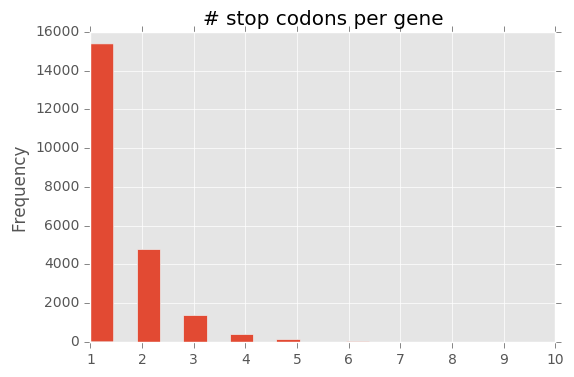

In [41]:
ax = scc_df.drop(['clv_site', 'scc_per_cs'], axis=1).drop_duplicates().scc_per_gene.plot.hist(bins=20)
ax.set_title('# stop codons per gene')

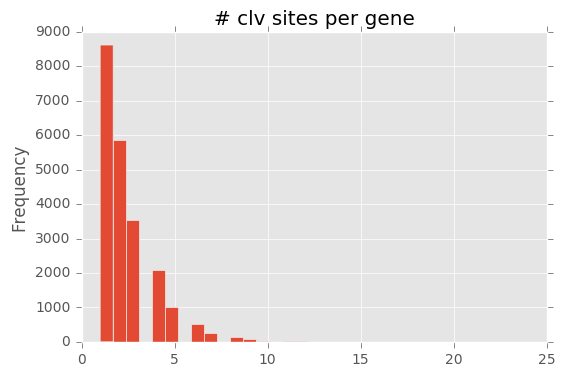

In [42]:
ax = scc_df.groupby('gene_id').count()['clv_site'].plot.hist(bins=30)
ax.set_title('# clv sites per gene')

In [43]:
# scc_df.groupby('gene_id').count()['clv_site'].value_counts()

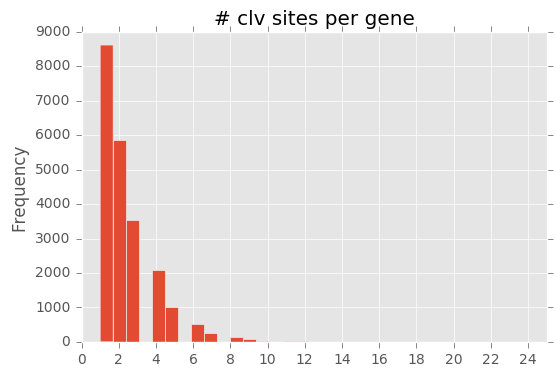

In [44]:
ax = scc_df.groupby('gene_id').count()['clv_site'].plot.hist(bins=30)
ax.set_title('# clv sites per gene')
ax.set_xticks(np.arange(0, 25, 2))

A gene can have up to 22 clv sites or 10 stop codons

In [45]:
scc_df.query('scc_per_gene > 1').gene_id.unique().shape[0] / float(num_genes)

0.3065236012803751

In [46]:
scc_df.query('(scc_per_gene > 1) & (scc_per_cs > 1)').shape[0] / float(scc_df.query('scc_per_gene > 1').shape[0])

0.05708017715965065

In [47]:
scc_df.query('(scc_per_gene > 1) & (scc_per_cs > 1) & (scc_per_cs < scc_per_gene)').shape[0] / float(scc_df.query('(scc_per_cs > 1)').shape[0])

0.45685279187817257

Based on the annotation, about 31% of the protein coding genes have more than one stop codons. Among them, 5.7% of their cleavage sites are mapped to over 1 stop codons, yet of which, 46% do not map to all available stop codons of their respective genes.

#### Now look at ratio more quantitatively

In [48]:
scc_df['ratio'] = scc_df.scc_per_cs / scc_df.scc_per_gene

In [50]:
scc_df['ratio_in_str'] = scc_df.scc_per_cs.astype(str) + '/' + scc_df.scc_per_gene.astype(str)

In [51]:
ratio_df = scc_df.ratio_in_str.value_counts().to_frame(name='count')

In [52]:
ratio_df['sort_key'] = ratio_df.index.map(lambda s: [int(_) for _ in s.split('/')[::-1]])

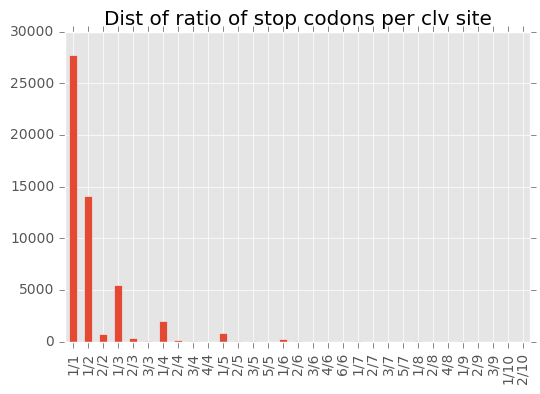

In [53]:
ax = ratio_df.sort_values('sort_key')['count'].plot.bar()
ax.set_title('Dist of ratio of stop codons per clv site')

In [54]:
ratio_df.sort_values('sort_key')['count'].to_frame().T

,1/1,1/2,2/2,1/3,2/3,3/3,1/4,2/4,3/4,4/4,1/5,2/5,3/5,5/5,1/6,2/6,3/6,4/6,6/6,1/7,2/7,3/7,5/7,1/8,2/8,4/8,1/9,2/9,3/9,1/10,2/10
count,27740,14050,711,5445,370,33,1997,115,21,2,839,50,33,2,286,14,3,1,1,102,6,4,1,29,4,1,23,4,1,9,2


So many cases of how stop codons are used are possible, but they're neither random nor exhaustively

### How many transcripts don't have UTR?

In [58]:
ndf = df.query('source == "protein_coding"').query('feature != "gene"')

In [59]:
ndf.head(2)

,seqname,source,feature,start,end,score,strand,frame,len,transcript_id,gene_id,gene_name
110,1,protein_coding,transcript,69091,70008,.,+,.,918,ENST00000335137,ENSG00000186092,OR4F5
111,1,protein_coding,exon,69091,70008,.,+,.,918,ENST00000335137,ENSG00000186092,OR4F5


In [60]:
for (k, g) in ndf.groupby('transcript_id'):
    break

In [67]:
%time has_utr_df = ndf.groupby('transcript_id').apply(lambda grp: grp.query('feature == "UTR"').shape[0] > 0)

CPU times: user 1min 42s, sys: 33 ms, total: 1min 42s
Wall time: 1min 42s


In [68]:
has_utr_df.value_counts()

True     85661
False     4612
dtype: int64

In [72]:
4612 / 85661.

0.05384013728534572

So 5.4% of the annotated transcripts don't have UTR

In [69]:
%time has_sc_df = ndf.groupby('transcript_id').apply(lambda grp: grp.query('feature == "stop_codon"').shape[0] > 0)

CPU times: user 1min 42s, sys: 40 ms, total: 1min 42s
Wall time: 1min 42s


In [70]:
has_sc_df.value_counts()

True     62800
False    27473
dtype: int64

In [73]:
27473 / 62800.

0.437468152866242

44% of annotated transcripts don't have stop codons!!! How come?
Ans: there are transcripts that have UTR but not stop codons annotated: e.g. BRCA2-ENST00000470094, BRCA2-ENST00000470094, DRAM1-ENST00000549365, but the are three are all nonsense_mediated_decay (NMD). However, PIK3R1-ENST00000517698 is also a NMD, but it has annotated start and stop codons. Confused :(